# Financial Option Pricing with Quantum Computing
This notebook is a part of the [presentation](https://github.com/dawidkopczyk/training/blob/master/WQCG_2020_Quantum_Monte_Carlo_Tutorial/WQCG_2020_Quantum_Monte_Carlo.pdf) on 25th May 2020 at Warsaw Quantum Computing Group meeting by Dawid Kopczyk. 

The notebook is divided into three sections: 
- Example: Black-Scholes
- Example: Monte Carlo method
- Example: Quantum Algorithm for Monte Carlo

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
%matplotlib inline

 ## Example: Black-Scholes
 In this example we will calculate a price of European call option at $t=0$. 
 
 Firstly, let's calculate a payoff for European call option at time T.

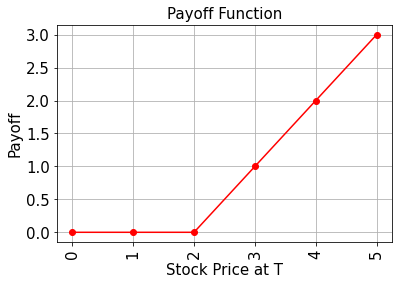

In [2]:
# Generate payoff values (C) for stock price (S) at time T
K = 2
S = np.arange(0,6)
C = np.maximum(0, S - K)

# Plot payoff function
plt.plot(S, C, 'ro-')
plt.grid()
plt.title('Payoff Function', size=15)
plt.xlabel('Stock Price at T', size=15)
plt.ylabel('Payoff', size=15)
plt.xticks(S, size=15, rotation=90)
plt.yticks(size=15)
plt.show()

We define a function `euro_vanilla_call` calculating the price $\mathbb{E}(C_t)$ of an European call option at time $t$ using Black-Scholes model.

In [3]:
def euro_vanilla_call(S_t, K, T, r, sigma, t=0):
    
    # S_0: stock price at t=0
    # K: strike price
    # T: time to maturity from t=0
    # r: interest rate
    # sigma: volatility of underlying asset
    
    d1 = (np.log(S_t / K) + (r + 0.5 * sigma ** 2) * (T-t)) / (sigma * np.sqrt(T-t))
    d2 = d1 - sigma * np.sqrt(T-t)
    
    C = (S_t * norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * (T-t)) * norm.cdf(d2, 0.0, 1.0))
    
    return C

The price of an option with strike price $K=2$, the initial stock price at $t=0$ is 1.5 and the time to maturity is 1 year. The volatility $\sigma$ is assumed to be 0.25.

In [4]:
S_0 = 1.5
K = 2
T = 1
r = 0.05
sigma = 0.25

C_black_scholes = euro_vanilla_call(S_0, K, T, r, sigma)
print('The price of european call option E(C_0) = {:.4f}'.format(C_black_scholes))

The price of european call option E(C_0) = 0.0384


## Example: Monte Carlo method

In this example, we will show that the Monte-Carlo method can recover Black Scholes result. 

Firstly, we define a function `generate_asset_price` generating a stock price at $T$. Stock prices follows the log-normal distribution:
$$S_T=S_t e^{(r−\frac{1}{2}\sigma^2)(T−t)+\sigma \sqrt{T−t}\epsilon}$$
where $\epsilon \sim N(0,1)$.

In [5]:
def generate_asset_price(S_t, T, r, sigma, t=0):
    return S_t * np.exp((r - 0.5 * sigma**2) * (T-t) + sigma * np.sqrt(T-t) * norm.rvs(0, 1.0))

We generate $N$ scenarios of stock prices at maturity $T$: $(S_T^{(1)}, S_T^{(2)}, \cdots, S_T^{(N)})$

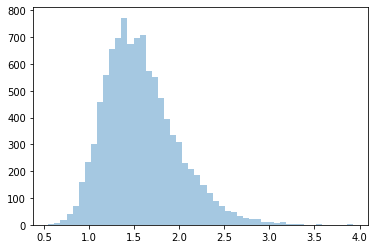

In [6]:
N = 10000

scenarios_S = []
for i in range(N):
    scenarios_S.append(generate_asset_price(S_0, T, r, sigma))
    
# Plot probability distribution
sns.distplot(scenarios_S, kde=False)

And we plug in the generated stock price scenarios $(S_T^{(1)}, S_T^{(2)}, \cdots, S_T^{(N)})$
to a formula calculating price of an option: 
$$E(C_t)=e^{r(T-t)}\mathbb{E}(\max{(S_T-K,0))}$$

,Spot Price,Strike,Option Price
0,1.437001,2.0,0.000000
1,1.278771,2.0,0.000000
2,1.540620,2.0,0.000000
3,1.613926,2.0,0.000000
4,0.986569,2.0,0.000000
5,1.744882,2.0,0.000000
6,2.404447,2.0,0.384722
7,1.818749,2.0,0.000000
8,1.732022,2.0,0.000000
9,1.125596,2.0,0.000000


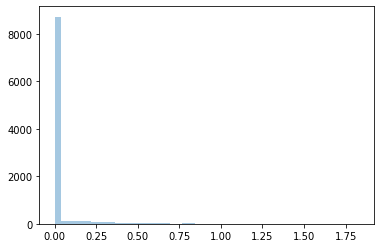

In [7]:
scenarios_C = np.exp(-r*T) * np.maximum(np.array(scenarios_S)-K,0)

import pandas as pd
df = pd.DataFrame(np.stack([np.array(scenarios_S), np.repeat(K,N), scenarios_C]).T, 
                  columns=['Spot Price', 'Strike', 'Option Price'])
display(df.head(10))

sns.distplot(scenarios_C, kde=False)

In [8]:
C_monte_carlo = np.mean(scenarios_C)
print('The price of european call option calculated with Black Schloes = {:.4f}'.format(C_black_scholes))
print('The price of european call option calculated with Monte Carlo = {:.4f}'.format(C_monte_carlo))

The price of european call option calculated with Black Schloes = 0.0384
The price of european call option calculated with Monte Carlo = 0.0405


Monte Carlo method allows us to generate option prices when not only $S$ is random variable, but also $r$, $\sigma$ can be stochatic processes, even with correlation between them (it is realistic to assume that equity prices will be highly correlated to interest rates). 

Furthermore, log-normal distribution of stock prices was used only to be comparable with Black-Scholes. With Monte-Carlo we can use arbitrary probabilty distributions. 

## Example: Quantum Algortihm for Monte Carlo
In this section, we present how to run quantum algorithm for pricing financial option. We will use Qiskit SDK to simulate execution of algorithm on quantum computer + Qiskit already contains the algorithms required for this task.

In [9]:
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, BasicAer, Aer, IBMQ
from qiskit.aqua.algorithms import AmplitudeEstimation
from qiskit.finance.components.uncertainty_problems import EuropeanCallExpectedValue
from qiskit.aqua.components.uncertainty_models import LogNormalDistribution
# Loading your IBM Q account(s)
provider = IBMQ.load_account()

Firstly, we will generate unitary $\mathcal{A}$, which will build us an uncertainty model i.e. we will encode log-normal distribution of stock prices into a quantum state:
$$\mathcal{A}|0\rangle^n=\sum_{i=0}^{2^n-1}\sqrt{p_i}|i\rangle$$
so that $|i\rangle$ are realizations of $S_T$ mapped and discretized to $i=\{0,1,\dots,2^n-1\}$. 

[Grover and Rudolph (2002)](https://arxiv.org/abs/quant-ph/0208112) showed that $\mathcal{A}$ can be constructed. The best known upper bound for the number of gates constructing $\mathcal{A}$ is $\mathcal{O}(2^n)$, however approximations with polynominal complexity in $n$ are possible for many distrubitions for exaple log-concave distributions (log-normal is log-concave). The distributions can be also loaded using qGAN ([quantum Generative Adverserial Networks](https://arxiv.org/abs/1904.00043)). 

**Reminder**
$$S_T=S_t e^{(r−\frac{1}{2}\sigma^2)(T−t)+\sigma \sqrt{T−t}\epsilon}$$
where $\epsilon \sim N(0,1)$. From that we conclude that for $t=0$: 
$$log(S_T) \sim N\left((r−\frac{1}{2}\sigma^2)T+\log(S_0), \sigma \sqrt{T}\right)$$

In [10]:
# Number of qubits to represent the uncertainty
n = 4

# The same option characteristics as above
S_0 = 1.5
K = 2
T = 1
r = 0.05
sigma = 0.25

# Resulting normal mu and normal sigma from stock price log-normal distribution
normal_mu = ((r - 0.5 * sigma**2) * T + np.log(S_0))
normal_sigma = sigma * np.sqrt(T) 

# Lowest and highest value considered for the stock price; 
# in between, an equidistant discretization is considered.
mean = np.exp(normal_mu + 0.5 * normal_sigma**2)
variance = (np.exp(normal_sigma**2) - 1) * np.exp(2*normal_mu + normal_sigma**2)
stddev = np.sqrt(variance)

low = np.maximum(0, mean - 4*stddev)
high = mean + 4*stddev

# Construct circuit factory A for uncertainty model
circuit_A = LogNormalDistribution(n, 
                                  mu=normal_mu, sigma=normal_sigma,  
                                  low=low, high=high)

In [11]:
S = circuit_A.values
prob = circuit_A.probabilities

print('The number of considered stock prices: 2^{}={}. The stock prices are '
      'in range [{:.4f}, {:.4f}].'.format(n, S.size, low, high))

The number of considered stock prices: 2^4=16. The stock prices are in range [0.0000, 3.1788].


Since we use the same characteristics of stock prices, the distriubtion of stocks prices is very similar the one plotted in *Example: Monte Carlo method* section.

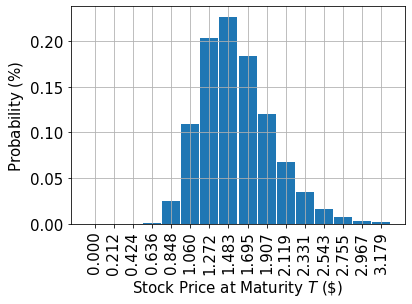

In [12]:
# Plot probability distribution
plt.bar(S, prob, width=0.2)
plt.xticks(S, size=15, rotation=90)
plt.yticks(size=15)
plt.grid()
plt.xlabel('Stock Price at Maturity $T$ (\$)', size=15)
plt.ylabel('Probability ($\%$)', size=15)
plt.show()

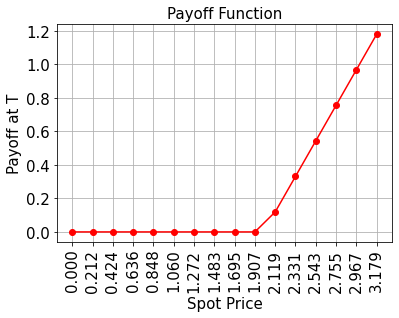

In [18]:
# Plot payoff function (evaluated on the grid of the uncertainty model)
C = np.maximum(0, S - K)
plt.plot(S, C, 'ro-')
plt.grid()
plt.title('Payoff Function', size=15)
plt.xlabel('Spot Price', size=15)
plt.ylabel('Payoff at T', size=15)
plt.xticks(S, size=15, rotation=90)
plt.yticks(size=15)
plt.show()

The uncertainty model gives us a slightly different option price than one from Black-Scholes model or Monte-Carlo method - this is due to the **discretization error**. 

In [20]:
# Evaluate expected option price according to uncertainty model 
C_uncertainty_model = np.exp(-r*T) * np.dot(prob, C)
print('The price of european call option according to '
      'uncertainty model = {:.4f}'.format(C_uncertainty_model))

The price of european call option according to uncertainty model = 0.0376


We construct a unitary $\mathcal{R}$ which will encode payoff function and perform the rotation of an ancilla qubit. This is done so that we are able to retrieve expected value $\mathbb{E}(C)$ from probabilty of measuring ancilla qubit in $|1\rangle$

$$\sum_{i=0}^{2^n-1}\sqrt{p_i}\sqrt{1-f(i)}|i\rangle|0\rangle+\sqrt{p_i}\sqrt{f(i)}|i\rangle|1\rangle$$
$$\mathbb{E}(C)=\sum_{i=0}^{2^n-1} p_i f(i)$$
where $f(i)$ is payoff function $v(S_T)$  normalized to output values in range $[0,1]$ with:
$$f(i)=\frac{v^*(i)-v_{min}^*}{v^*_{max}-v^*_{min}}-1$$
and $v^*(i)$ is the payoff function after mapping $S_T$ to $i$.

The payoff function is non-linear, however it consists of two parts:
- zero as long as $S_T \leq K$,
- linear part when $S_T > K$.

We can either find a quantum circuit as a binary approximation of payoff function (basic arithmetic
operations such as multiplication, max, etc can be represented by a set of $\textit{AND}$ gates and controlled Y rotations, for more details refer to [Quantum networks for elementary arithmetic operations (1996)](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.54.147)).

Alternatively, we can use the **approximation** presented in paper [Quantum Risk Analysis](https://arxiv.org/abs/1806.06893), which relies on a nice trick. 

We can easily construct an operator $\mathcal{R}$ that acts as
$$\mathcal{R}\big|x\rangle \big|0\rangle = \big|x\rangle \left( \cos(a*x+b) \big|0\rangle + \sin(a*x+b) \big|1\rangle \right),$$
using controlled Y-rotations.

Eventually, we are interested in the probability of measuring $\big|1\rangle$ in the last qubit, which corresponds to $P=\sin^2(a*x+b)$. Please note that $\sin^2(y + \frac{\pi}{4}) \approx y + \frac{1}{2}$ for small $|y|$. Thus, for a given approximation scaling factor $c_{approx} \in [0, 1]$ and $x \in [0, 1]$ we consider
$$ P=\sin^2\left( \frac{\pi}{2} c_{approx} \left( x - \frac{1}{2} \right) + \frac{\pi}{4} \right) \approx \frac{\pi}{2} c_{approx} \left( x - \frac{1}{2} \right) + \frac{1}{2} $$
for small $c_{approx}$.

The approximation of $v(S_T)=max(S_T-K,0)$ uses a comparator, that flips an ancilla qubit from $\big|0\rangle$ to $\big|1\rangle$ if $S_T \geq K$, and this ancilla is used to control the linear part of the payoff function. The linear part $x=S_T-K$ is then recovered from measured probablity $P=\sin^2( \pi/2 * c_{approx} * ( x - 1/2 ) + \pi/4)$ using the approximation above:
$$x=\frac{2P-1}{\pi c_{approx}}+\frac{1}{2}$$

The smaller we choose $c_{approx}$, the better the approximation. However, since we are then estimating a property scaled by $c_{approx}$, the number of evaluation qubits $m$ needs to be adjusted accordingly.

The `EuropeanCallExpectedValue` also prepares $\mathcal{Q}$ (described in the presentation) operator so that the circuit factory can be used directly in quantum phase estimation.  

In [26]:
# Set the approximation scaling for the payoff function
c_approx = 0.26

# Construct circuit factory for payoff function
european_call = EuropeanCallExpectedValue(
    circuit_A,
    strike_price=K,
    c_approx=c_approx
)

Now, we will use [Quantum Phase Estimation](http://dkopczyk.quantee.co.uk/qpe/) algorithm given unitary $\mathcal{Q}$ represented by `european_call` circuit factory to find eigenvalue $e^{\pm i\theta}$ of $\mathcal{Q}$. Having $\theta$ we can easily get value of $\mathbb{E}(f(i))$ from relation $1-2\mathbb{E}(f(i))=\cos(\theta)$ and then unmap from $f(i)$ to have $v(S_T)$. This is explained in details in the presentation.

The value of `m` specifies the number of evaluation qubits which impacts floating accuracy of the result.

In [27]:
# Set number of evaluation qubits (2^m = quantum samples)
m = 4

# Construct amplitude estimation 
ae = AmplitudeEstimation(m, european_call)

We run the algorithm on `statevector_simulator` - simulator of quantum computer without noise. You can play around with noise models using `qasm_simulator`.

In [28]:
# result = ae.run(quantum_instance=BasicAer.get_backend('qasm_simulator'), shots=100)
result = ae.run(quantum_instance=BasicAer.get_backend('statevector_simulator'))

In [29]:
result

{'statevector': array([[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]]),
 'shots': 1,
 'a_items': [(0.0, 0.00027858081832581543),
  (0.0380602, 0.0007508216799240212),
  (0.1464466, 0.0022440489932793674),
  (0.3086583, 0.9925521217828),
  (0.5, 0.002652369482474273),
  (0.6913417, 0.0007207840345623173),
  (0.8535534, 0.0003870557513798476),
  (0.9619398, 0.00028467349106353125),
  (1.0, 0.0001295439662486477)],
 'y_items': [(0, 0.00027858081832581543),
  (1, 0.00037541083996146585),
  (2, 0.0011220244966363613),
  (3, 0.4962760608914103),
  (4, 0.0013261847412327178),
  (5, 0.0003603920172804867),
  (6, 0.000193527875689709),
  (7, 0.00014233674553171998),
  (8, 0.0001295439662486477),
  (9, 0.00014233674553181127),
  (10, 0.00019352787569013857),
  (11, 0.0003603920172818306),
  (12, 0.0013261847412415551),
  (13, 0.4962760608913896),
  (14, 0.0011220244966430061),
  (15, 0.0003754108399625554)],
 'mapped_values': [-0.9209153914725503,
  -0.8024209987171497,
  -0.464977142643

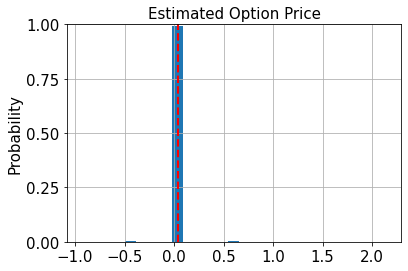

In [30]:
# Plot estimated values for option price (after re-scaling and reversing the c_approx-transformation)
plt.bar(np.exp(-r*T) * np.array(result['mapped_values']), result['probabilities'], 
        width=1/len(result['probabilities']))
plt.plot([C_uncertainty_model, C_uncertainty_model], [0,1], 'r--', linewidth=2)
plt.xticks(size=15)
plt.yticks([0, 0.25, 0.5, 0.75, 1], size=15)
plt.title('Estimated Option Price', size=15)
plt.ylabel('Probability', size=15)
plt.ylim((0,1))
plt.grid()
plt.show()

In [31]:
C_quantum_algo = np.exp(-r*T) * result['estimation']
print('The price of european call option according to '
      'uncertainty model = {:.4f}'.format(C_uncertainty_model))
print('The price of european call option according to '
      'quantum algorithm = {:.4f}. Drawed with probabilty: {:.2f}%'.format(C_quantum_algo, 
                                                                           100*result['max_probability']))

The price of european call option according to uncertainty model = 0.0376
The price of european call option according to quantum algorithm = 0.0381. Drawed with probabilty: 99.26%
